# Imports

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from src.parse_labeling import parse_labeled_file, parse_from_gradio, parse_mqm, map_rating_to_model
from src.parse_labeling import MQM_metrics, rating_gold_metrics, parse_single_file_gradio

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
df = pd.read_csv('labeled_files/mmlu_main_sub_TEST_labeled_gradio.csv')
# df = pd.read_csv('labeled_files/mmlu_main_sub_TEST_2_labeled_gradio.csv')
df = df.fillna('')
df.shape

In [ ]:
df['rating'].value_counts()

In [268]:
def query_to_sample(text):
    pattern = r"<(?!response_format\b)([^>]+)>(.*?)</\1>"
    matches = re.findall(pattern, text, re.DOTALL)
    return {key: value.strip() for key, value in matches}

In [274]:
# df = pd.read_csv('labeled_files/arc_ai_TEST_labeled_gradio.csv')
df = pd.read_csv('labeled_files/gsm_TEST_labeled_gradio.csv')
df.shape

(600, 16)

In [275]:
a = df['text_column'].apply(lambda x: len("".join(query_to_sample(x).values())))
b = df['new_text_column'].apply(lambda x: len("".join(query_to_sample(x).values())))

In [276]:
(1 - (b / a)).std(), (1 - (b / a)).mean(), (1 - (b / a)).quantile([0.01, 0.25, 0.5, 0.75, 0.99])

(0.07441680324024542,
 0.1554059916364523,
 0.01   -0.036151
 0.25    0.110800
 0.50    0.156327
 0.75    0.201726
 0.99    0.331430
 dtype: float64)

# Gemini-Claude Comparison

## with Israel's labels

### Read Data

In [256]:
def change_names(df, map_names):
    df['model 1'] = df['model 1'].apply(lambda x: map_names[x])
    df['model 2'] = df['model 2'].apply(lambda x: map_names[x])
    df['rating model'] = df['rating model'].apply(lambda x: map_names[x])
    return df

# Claude
change_names_model_claude = {
    'claude_4_opus_v7_thinking': 'claude 4 sonnet',
    'claude_3-7_v7_thinking': 'claude 3.7 sonnet',
    'BOTH': 'BOTH',
    'SKIP': 'SKIP',
    '': '',
}

# ARC-AI2 & GSM8K
change_names_model_arc_gsm = {
    'claude_v2_refine': 'claude 3.7 sonnet',
    'gemini_pro_think_v2': 'gemini pro 2.5',
    'BOTH': 'BOTH',
    'SKIP': 'SKIP',
    '': '',
}

# MMLU
change_names_model_mmlu = {
    'claude_thinking_v2': 'claude 3.7 sonnet',
    'claude_v1_refine': 'claude 3.7 sonnet',
    'gemini_pro_think_v1': 'gemini pro 2.5',
    'BOTH': 'BOTH',
    'SKIP': 'SKIP',
    '': '',
}

In [257]:
# CLAUDE
labels = 'labeled_files/claude_vers_labeled_gradio.csv'
csv_name = 'manual_compare/claude_vers_comparison_FULL.csv'
claude_label_df, claude_or_df = parse_from_gradio(labels, csv_name)
claude_or_df = change_names(claude_or_df, change_names_model_claude)

# ARC_AI2
labels = 'labeled_files/arc_ai_labeled_gradio.csv'
csv_name = 'manual_compare/arc_ai2_train_top_200_FULL.csv'
arc_label_df, arc_or_df = parse_from_gradio(labels, csv_name)
arc_or_df = change_names(arc_or_df, change_names_model_arc_gsm)

# GSM8K
labels = 'labeled_files/gsm8k_labeled_gradio.csv'
csv_name = 'manual_compare/gsm8k_169_FULL.csv'
gsm_label_df, gsm_or_df = parse_from_gradio(labels, csv_name)
gsm_or_df = change_names(gsm_or_df, change_names_model_arc_gsm)

# Read MMLU with single file
mmlu_labels_name = 'labeled_files/mmlu_test_labeled_gradio.csv'
mmlu_or_df = parse_single_file_gradio(mmlu_labels_name)
mmlu_label_df = mmlu_or_df
mmlu_or_df = change_names(mmlu_or_df, change_names_model_mmlu)

In [258]:
mmlu_label_df = mmlu_label_df[mmlu_or_df['rating'] != '']
mmlu_or_df = mmlu_or_df[mmlu_or_df['rating'] != '']

### Graphs

In [259]:
arc_or_df['rating model'].value_counts()

rating model
gemini pro 2.5       90
claude 3.7 sonnet    54
BOTH                 42
SKIP                  9
Name: count, dtype: int64

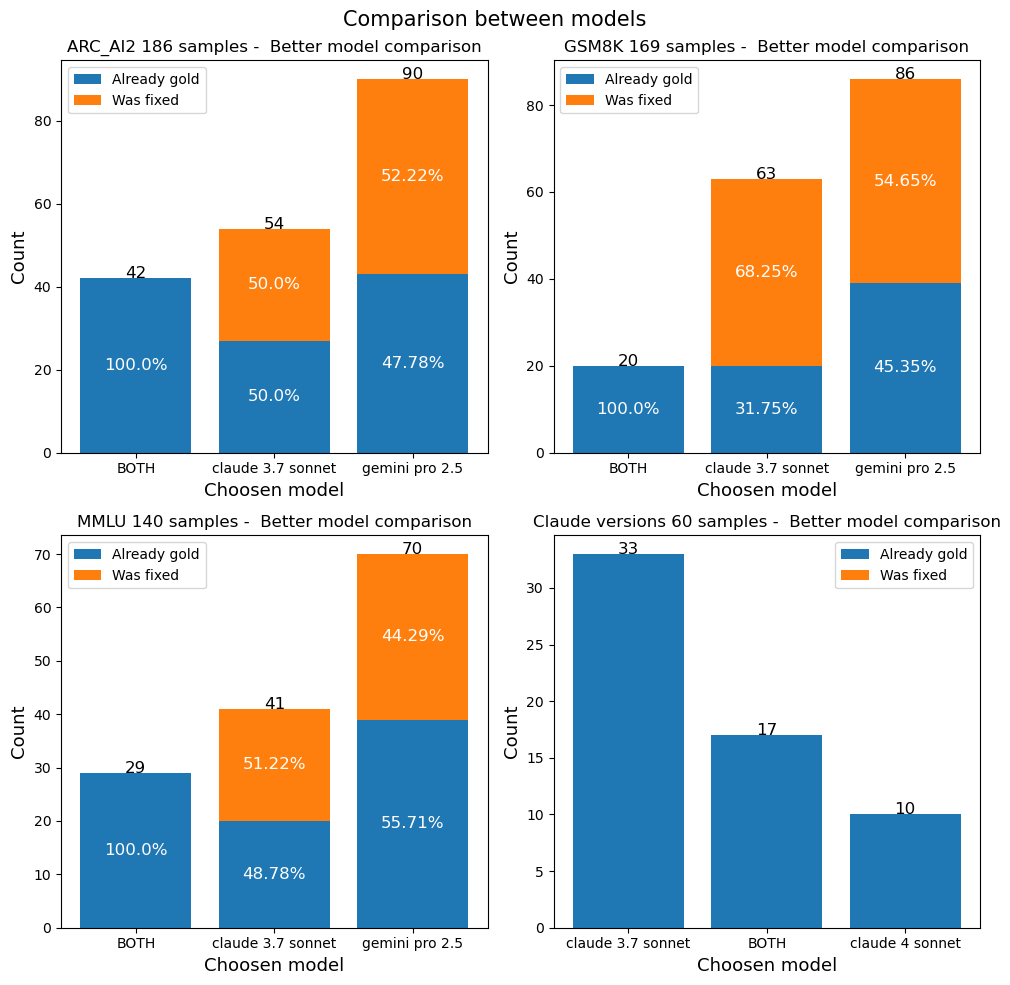

In [260]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10)) #, constrained_layout=True)

rating_gold_metrics(arc_or_df, f'ARC_AI2 {arc_or_df.shape[0] - (arc_or_df["rating model"] == "SKIP").sum()} samples - ', ax=axs[0, 0])
rating_gold_metrics(gsm_or_df, f'GSM8K {gsm_or_df.shape[0] - (gsm_or_df["rating model"] == "SKIP").sum()} samples - ', ax=axs[0, 1])
rating_gold_metrics(mmlu_or_df, f'MMLU {mmlu_or_df.shape[0] - (mmlu_or_df["rating model"] == "SKIP").sum()} samples - ', ax=axs[1, 0])
rating_gold_metrics(claude_or_df, f'Claude versions {claude_or_df.shape[0] - (claude_or_df["rating model"] == "SKIP").sum()} samples - ', False, ax=axs[1, 1])

fig.subplots_adjust(hspace=0.25, wspace=0.25)
fig.suptitle('Comparison between models', y=0.98, fontsize=15)
for i in range(2):
    for j in range(2):
        axs[i, j].set_xlabel(axs[i, j].get_xlabel(), fontsize=13)
        axs[i, j].set_ylabel(axs[i, j].get_ylabel(), fontsize=13)

fig.tight_layout()
plt.savefig('plots/Rating comparison.jpeg')
plt.show()

MQM average scores:
	claude 3.7 sonnet    - 1.3064516129032258
	gemini pro 2.5       - 0.7634408602150538

	There is a correlation in the MQM scores of: 0.764


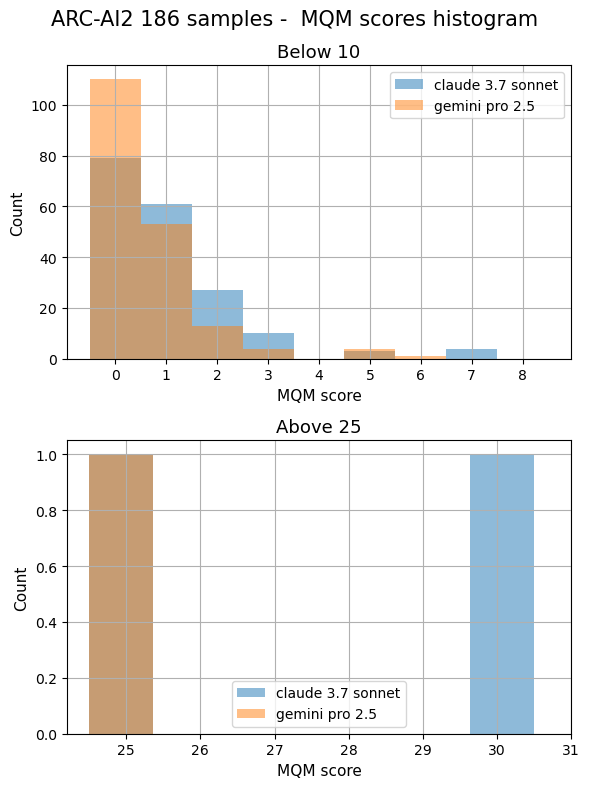


------------------------------


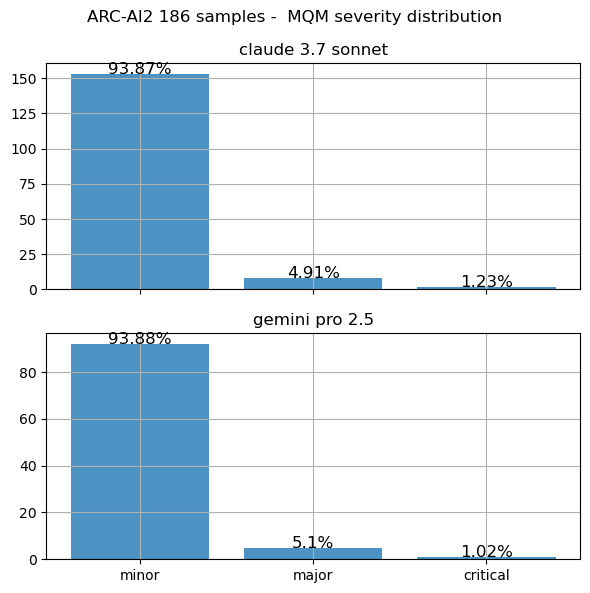


------------------------------


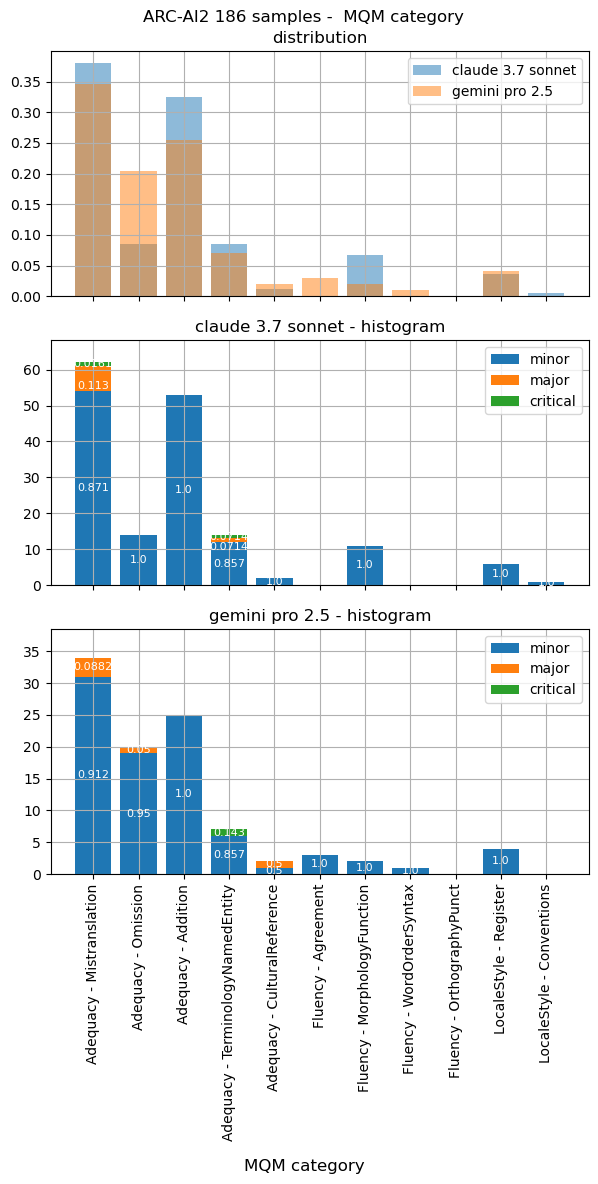

In [261]:
mqm_res, mqm_score = parse_mqm(arc_or_df[arc_or_df['rating model'] != 'SKIP'], arc_label_df[arc_or_df['rating model'] != 'SKIP'])
MQM_metrics(mqm_res, mqm_score, f'ARC-AI2 {arc_or_df.shape[0] - (arc_or_df["rating model"] == "SKIP").sum()} samples - ', 'arc_ai2')

MQM average scores:
	claude 3.7 sonnet    - 1.319526627218935
	gemini pro 2.5       - 0.9112426035502958

	There is a correlation in the MQM scores of: 0.291


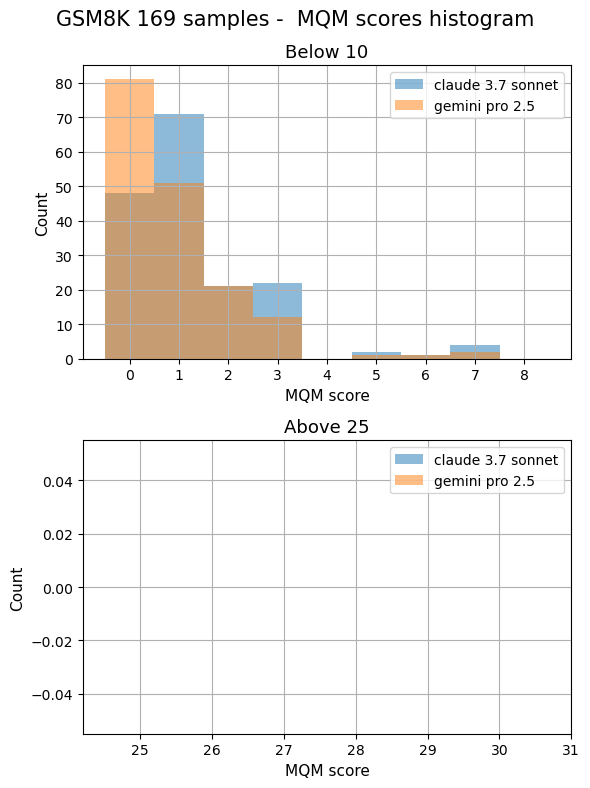


------------------------------


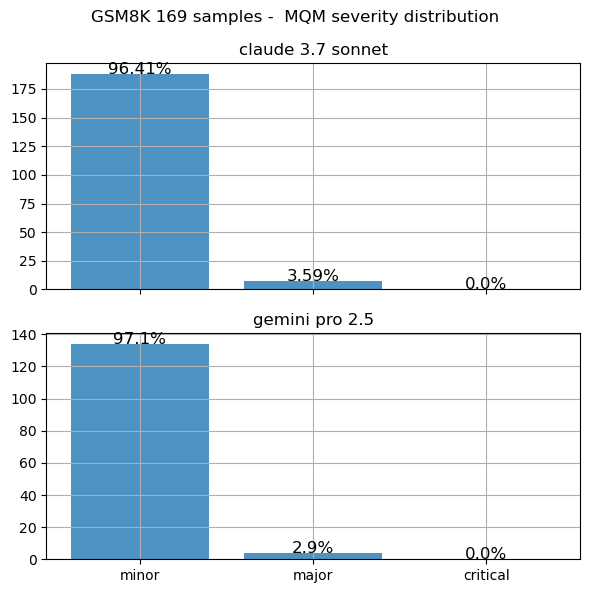


------------------------------


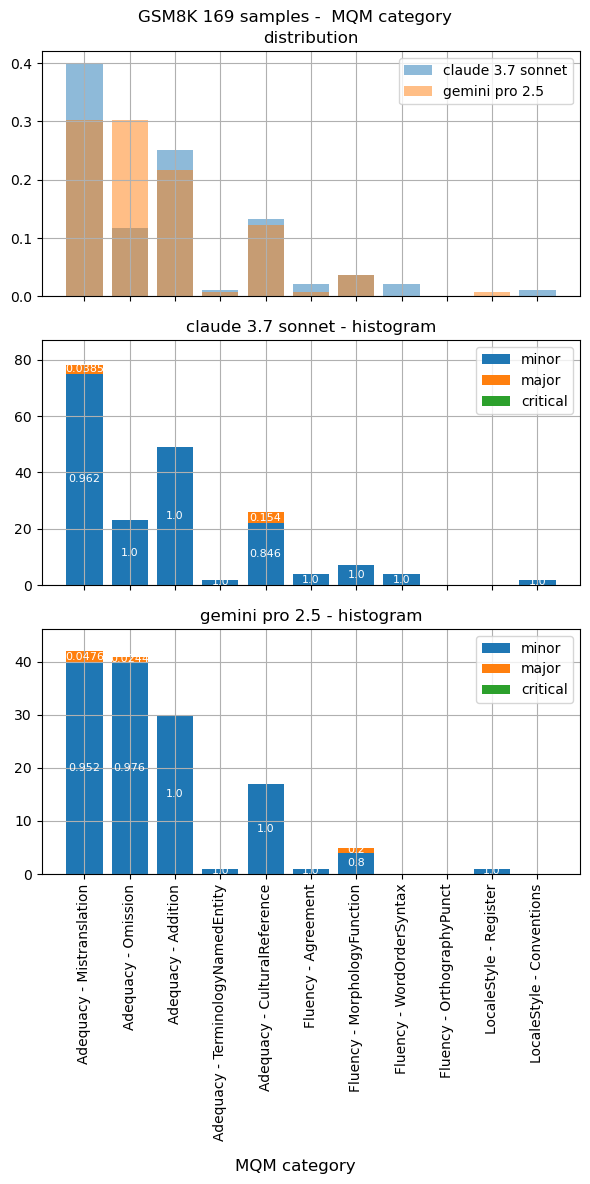

In [262]:
mqm_res, mqm_score = parse_mqm(gsm_or_df[gsm_or_df['rating model'] != 'SKIP'], gsm_label_df[gsm_or_df['rating model'] != 'SKIP'])
MQM_metrics(mqm_res, mqm_score, f'GSM8K {gsm_or_df.shape[0] - (gsm_or_df["rating model"] == "SKIP").sum()} samples - ', 'gsm')

MQM average scores:
	claude 3.7 sonnet    - 1.4357142857142857
	gemini pro 2.5       - 1.3142857142857143

	There is a correlation in the MQM scores of: 0.316


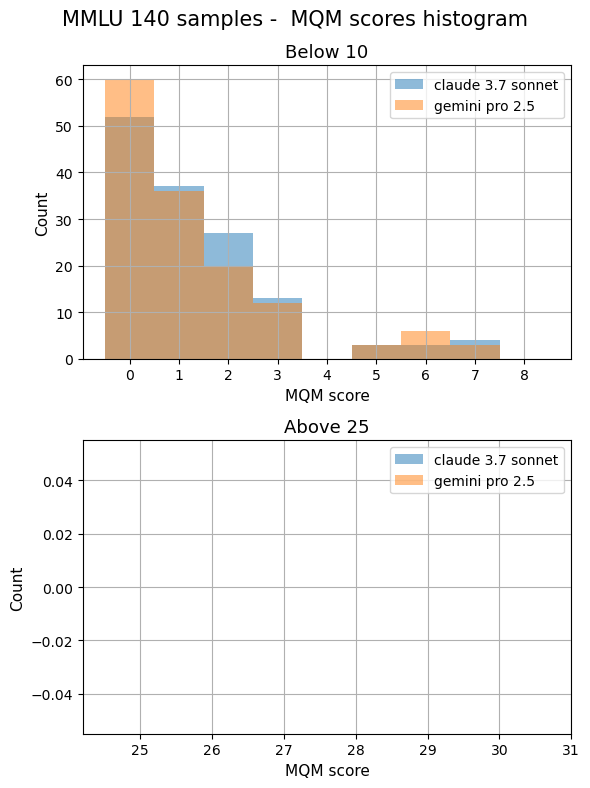


------------------------------


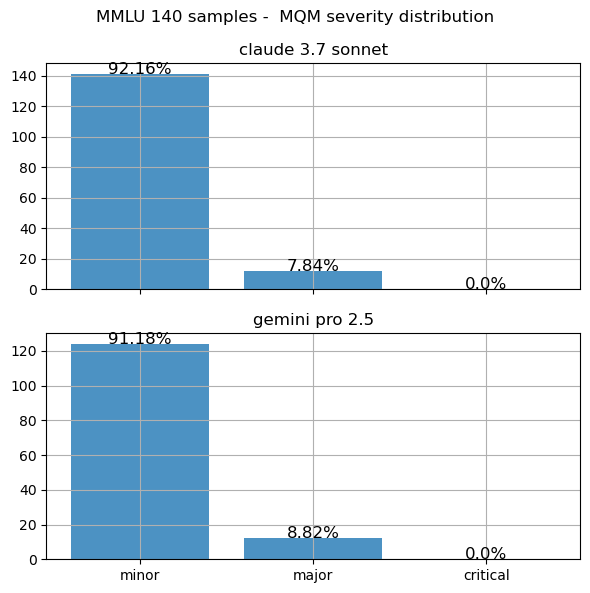


------------------------------


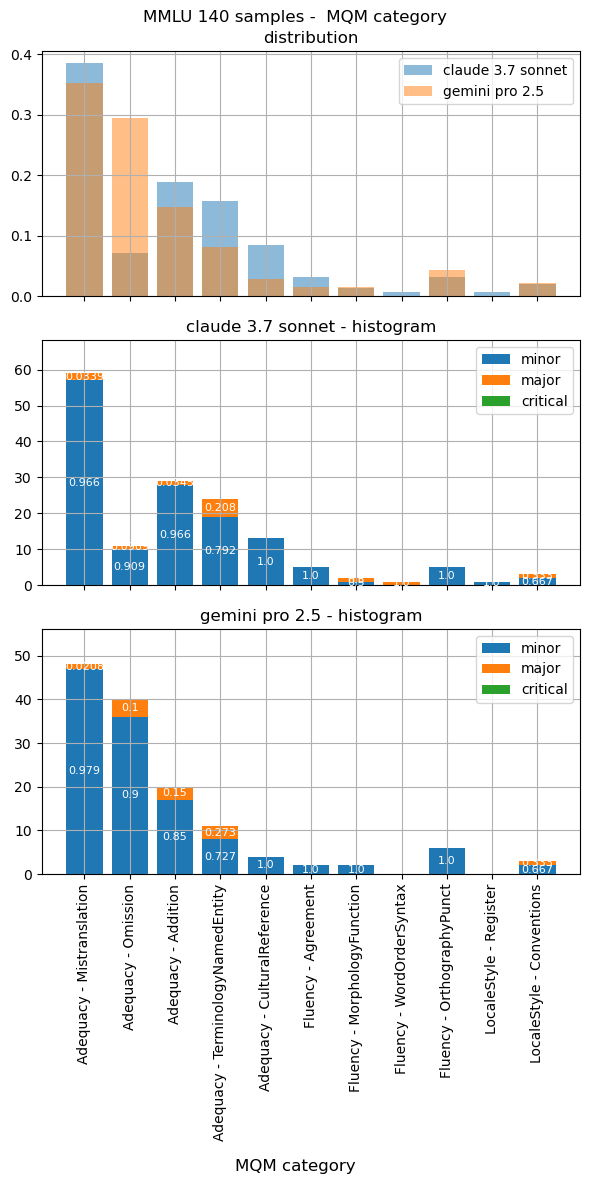

In [263]:
mqm_res, mqm_score = parse_mqm(mmlu_or_df[mmlu_or_df['rating model'] != 'SKIP'], mmlu_label_df[mmlu_or_df['rating model'] != 'SKIP'])
MQM_metrics(mqm_res, mqm_score, f'MMLU {mmlu_or_df.shape[0] - (mmlu_or_df["rating model"] == "SKIP").sum()} samples - ', 'mmlu')

## Israel-Guy Overlap

### Read Data

In [282]:
overlap_df_1 = pd.read_csv('labeled_files/overlap_israel.csv')
overlap_df_2 = pd.read_csv('labeled_files/overlap_gradio.csv')

overlap_df_1 = overlap_df_1.fillna('')
overlap_df_2 = overlap_df_2.fillna('')

# Fixing
overlap_df_1.loc[85, 'rating'] = 'SKIP'

assert (overlap_df_1['text_column'] == overlap_df_2['text_column']).all(), "mismatch between the overlaping dataframes - English"
assert (overlap_df_1['new_text_column'] == overlap_df_2['new_text_column']).all(), "mismatch between the overlaping dataframes - Hebrew"

overlap_df_1.shape, overlap_df_2.shape

((90, 17), (90, 17))

In [283]:
arc_or = pd.read_csv('manual_compare/arc_ai2_train_top_200_FULL.csv').iloc[10:40]
arc_or.index = range(30)
gsm_or = pd.read_csv('manual_compare/gsm8k_169_FULL.csv').iloc[10:40]
gsm_or.index = range(30, 60)
mmlu_or = pd.read_csv('manual_compare/mmlu_test_each_90_FULL.csv').iloc[10:40]
mmlu_or.index = range(60, 90)

assert (arc_or['original'] == overlap_df_1.iloc[:30]['text_column']).all(), "problem with arc"
assert (gsm_or['original'] == overlap_df_1.iloc[30:60]['text_column']).all(), "problem with gsm"
assert (mmlu_or['original'] == overlap_df_1.iloc[60:]['text_column']).all(),  "problem with mmlu"

In [284]:
# names mapping
change_names_overlap = {
    'claude_v2_refine': 'claude',
    'claude_thinking_v2': 'claude',
    'claude_v1_refine': 'claude',
    'gemini_pro_think_v2': 'gemini',
    'gemini_pro_think_v1': 'gemini',
    'BOTH': 'BOTH',
    'SKIP': 'SKIP',
    '': '',
}

# Add models
# loc includes the final number (not like 'range' or 'iloc'....)
for df in [overlap_df_1, overlap_df_2]:
    df.loc[:29, 'rating'] = df.iloc[:30].apply(lambda x: map_rating_to_model(x, arc_or), axis=1)
    df.loc[30:59, 'rating'] = df.iloc[30:60].apply(lambda x: map_rating_to_model(x, gsm_or), axis=1)
    df.loc[60:, 'rating'] = df.iloc[60:].apply(lambda x: map_rating_to_model(x, mmlu_or), axis=1)

    df['rating'] = df['rating'].map(change_names_overlap)

### Graphs

#### Cohen's Kappa

In [291]:
overlap_df_1['rating'].iloc[span[0]:span[1]]

60    gemini
61      SKIP
62    claude
63      BOTH
64    claude
65    claude
66    gemini
67    gemini
68    claude
69    claude
70      SKIP
71      SKIP
72      SKIP
73    claude
74      SKIP
75    gemini
76      BOTH
77    claude
78    claude
79    gemini
80      BOTH
81    gemini
82      BOTH
83      SKIP
84      BOTH
85      SKIP
86      SKIP
87      SKIP
88    gemini
89      BOTH
Name: rating, dtype: object

In [332]:
titles_lst = ['All Benchmarks', 'ARC-AI2', 'GSM8K', 'MMLU']
span_lst = [(0, 90), (0, 30), (30, 60), (60, 90)]

for i, j, span, title in zip([0, 0, 1, 1], [0, 1, 0, 1], span_lst, titles_lst):
    print(title)
    cm = confusion_matrix(overlap_df_1['rating'].iloc[span[0]:span[1]], overlap_df_2['rating'].iloc[span[0]:span[1]], labels=['gemini', 'claude', 'BOTH'])
    p0 = cm.trace() / cm.sum()
    pe = ((cm.sum(axis=0) / cm.sum()) * (cm.sum(axis=1) / cm.sum())).sum()
    kappa = (p0 - pe) / (1 - pe)
    # print(f'{p0:.2f}, {pe:.2f}, {kappa:.2f}')
    print(f'{kappa:.2f}')
    # display(cm)
    print()

All Benchmarks
0.18

ARC-AI2
0.08

GSM8K
0.06

MMLU
0.35



#### Rating (better model) agreement

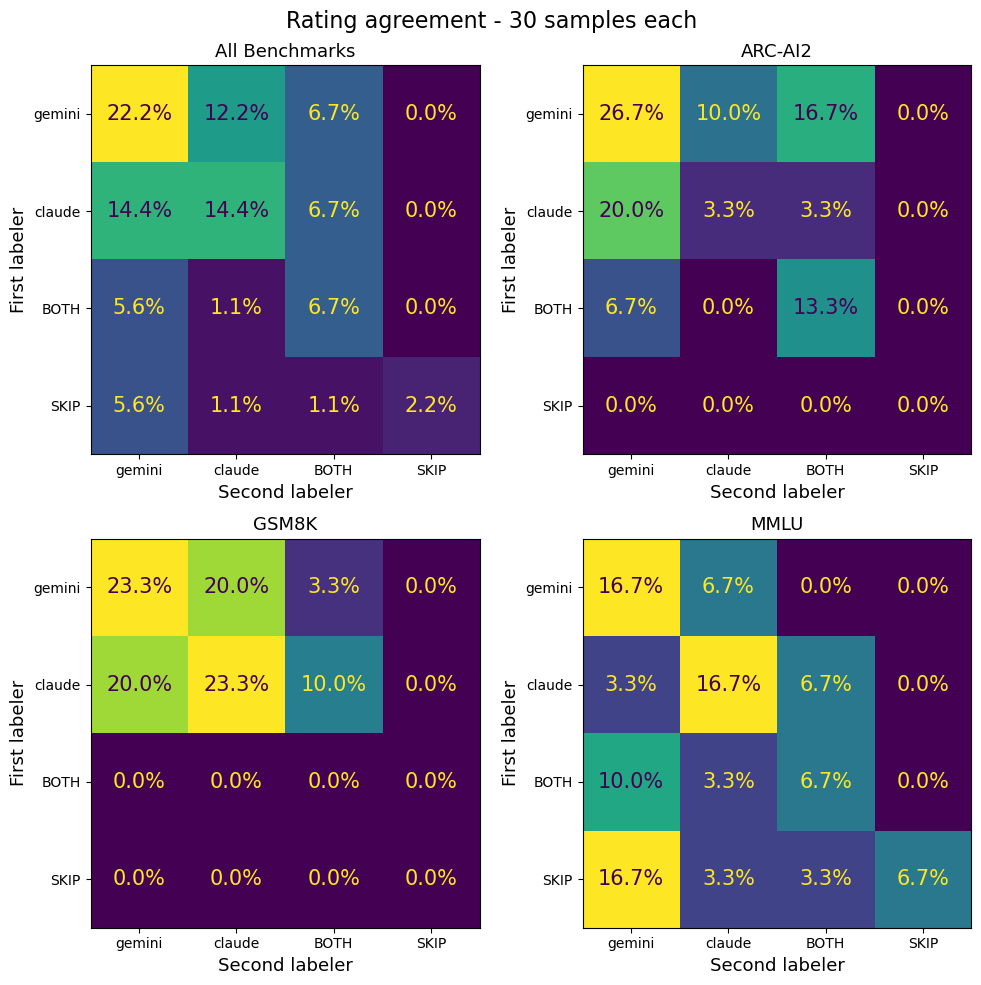

In [285]:
titles_lst = ['All Benchmarks', 'ARC-AI2', 'GSM8K', 'MMLU']
span_lst = [(0, 90), (0, 30), (30, 60), (60, 90)]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, j, span, title in zip([0, 0, 1, 1], [0, 1, 0, 1], span_lst, titles_lst):
    disp = ConfusionMatrixDisplay.from_predictions(overlap_df_1['rating'].iloc[span[0]:span[1]], overlap_df_2['rating'].iloc[span[0]:span[1]], ax=axs[i, j], colorbar=False, text_kw={'size': 15}, labels=['gemini', 'claude', 'BOTH', 'SKIP'], normalize='all', values_format='.1%')
    axs[i, j].set_ylabel('First labeler', fontsize=13)
    axs[i, j].set_xlabel('Second labeler', fontsize=13)
    axs[i, j].set_title(f'{title}', fontsize=13)
    
fig.suptitle(f'Rating agreement - 30 samples each', fontsize=16)
fig.tight_layout()
plt.savefig(f'plots/overlap_rating_cm.jpeg')
plt.show()

#### Gemini gold-fixing agreement

In [47]:
labeler_1_lst = [
    pd.read_csv('labeled_files/arc_ai_TEST_labeled_gradio.csv').tail(50).reset_index(drop=True),
    pd.read_csv('labeled_files/gsm_TEST_labeled_gradio.csv').tail(50).reset_index(drop=True),
]
labeler_2_lst = [
    pd.read_csv('labeled_files/arc_ai_TEST_2_labeled_gradio.csv').iloc[1:51].reset_index(drop=True),
    pd.read_csv('labeled_files/gsm_TEST_2_labeled_gradio.csv').head(50).reset_index(drop=True),
]

labeler_1_lst = [pd.concat(labeler_1_lst, ignore_index=True)] + labeler_1_lst
labeler_2_lst = [pd.concat(labeler_2_lst, ignore_index=True)] + labeler_2_lst

for df in labeler_1_lst + labeler_2_lst:
    df.fillna('', inplace=True)

for df_1, df_2 in zip(labeler_1_lst, labeler_2_lst):
    assert (df_1['text_column'] == df_2['text_column']).all(), "mismatch between the overlaping dataframes - English"
    assert (df_1['new_text_column'] == df_2['new_text_column']).all(), "mismatch between the overlaping dataframes - Hebrew"

/tmp/ipykernel_29004/2430511174.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)


In [61]:
(labeler_2_lst[1]['gold'] != '').sum(), (labeler_1_lst[1]['gold'] != '').sum()

(20, 7)

In [319]:
titles_lst = ['All Benchmarks', 'ARC-AI2', 'GSM8K', 'MMLU']
span_lst = [(0, 90), (0, 30), (30, 60), (60, 90)]

for df_1, df_2, title in zip(labeler_1_lst, labeler_2_lst, titles_lst):
    print(title)
    cm = confusion_matrix(df_1['gold'] != '', df_2['gold'] != '', labels=[False, True])
    p0 = cm.trace() / cm.sum()
    pe = ((cm.sum(axis=0) / cm.sum()) * (cm.sum(axis=1) / cm.sum())).sum()
    kappa = (p0 - pe) / (1 - pe)
    print(f'{p0:.2f}, {pe:.2f}, {kappa:.2f}')
    display(cm)
    print()

All Benchmarks
0.64, 0.58, 0.15


array([[52, 21],
       [15, 12]])


ARC-AI2
0.58, 0.57, 0.02


array([[26, 17],
       [ 4,  3]])


GSM8K
0.70, 0.55, 0.34


array([[26,  4],
       [11,  9]])

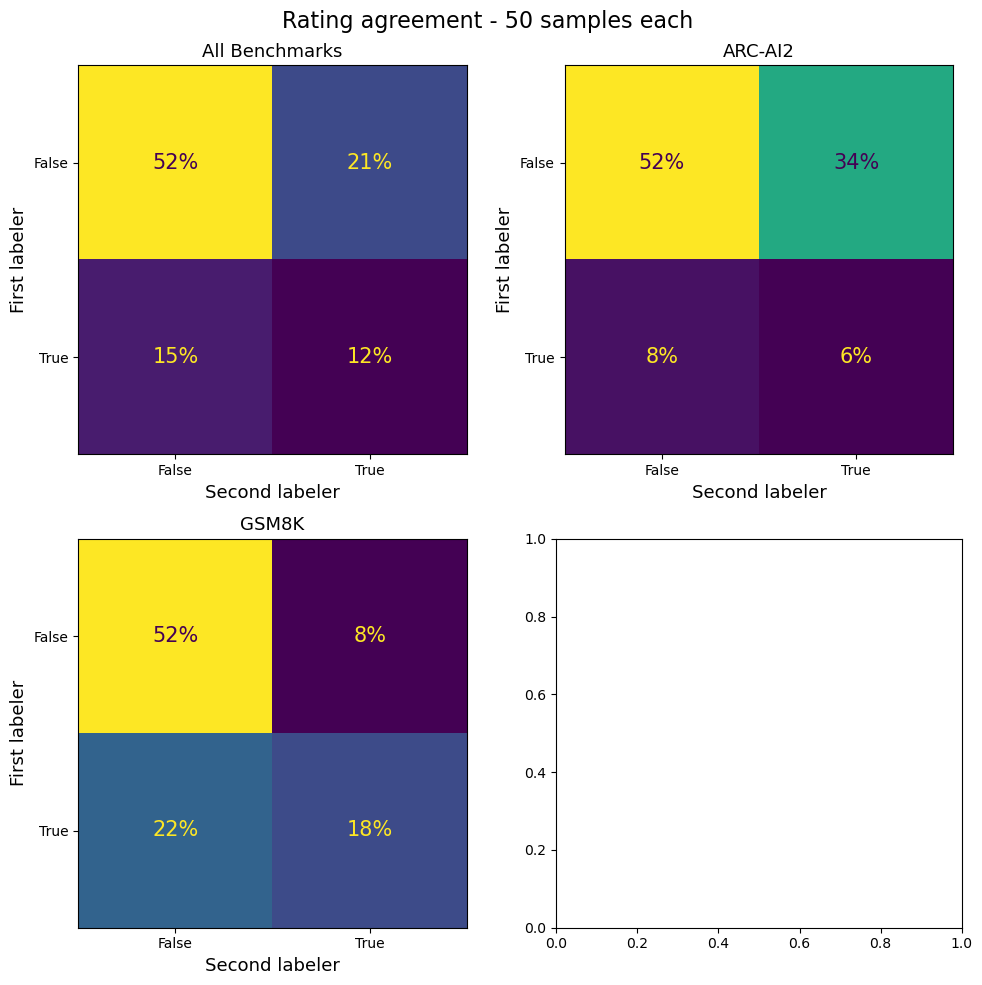

In [109]:
titles_lst = ['All Benchmarks', 'ARC-AI2', 'GSM8K', 'MMLU']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, j, df_1, df_2, title in zip([0, 0, 1, 1], [0, 1, 0, 1], labeler_1_lst, labeler_2_lst, titles_lst):
    disp = ConfusionMatrixDisplay.from_predictions(df_1['gold'] != '', df_2['gold'] != '', ax=axs[i, j], colorbar=False, text_kw={'size': 15}, labels=[False, True]) #, normalize='all', values_format='.0%') 
    axs[i, j].set_ylabel('First labeler', fontsize=13)
    axs[i, j].set_xlabel('Second labeler', fontsize=13)
    axs[i, j].set_title(f'{title}', fontsize=13)
    
fig.suptitle(f'Rating agreement - 50 samples each', fontsize=16)
fig.tight_layout()
plt.savefig(f'plots/overlap_gemini_fix.jpeg')
plt.show()

#### MQM scores agreement

In [81]:
from src.parse_labeling import map_mqm_to_score

In [84]:
sev_cols_1 = [f'severity_annotation_{i}' for i in [1, 2, 3]]
sev_cols_2 = [f'severity_annotation_{i}' for i in [4, 5, 6]]

use_rows = ~((overlap_df_1['rating'] == 'SKIP') | (overlap_df_2['rating'] == 'SKIP'))
# use_rows = use_rows * False + True

scores_1 = pd.concat([overlap_df_1[use_rows][sev_cols_1].map(lambda x: map_mqm_to_score[x]).sum(axis=1), overlap_df_1[use_rows][sev_cols_2].map(lambda x: map_mqm_to_score[x]).sum(axis=1)], ignore_index=True)
scores_2 = pd.concat([overlap_df_2[use_rows][sev_cols_1].map(lambda x: map_mqm_to_score[x]).sum(axis=1), overlap_df_2[use_rows][sev_cols_2].map(lambda x: map_mqm_to_score[x]).sum(axis=1)], ignore_index=True)

scores_1.corr(scores_2)

0.12210267698971368

In [417]:
mqm_map = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    5: 'major',
    6: 'major',
    7: 'major',
    10: 'major',
    25: 'critical',
    26: 'critical',
    30: 'critical',
}

mqm_map_sev = {
    0: '0',
    1: 'minor',
    2: 'minor',
    3: 'minor',
    5: 'major',
    6: 'major',
    7: 'major',
    10: 'major',
    25: 'critical',
    26: 'critical',
    30: 'critical',
}

In [419]:
mqm_score_kappa = 0

cm = confusion_matrix(
    scores_1.apply(lambda x: mqm_map_sev[x]),
    scores_2.apply(lambda x: mqm_map_sev[x]),
    labels = ['0', 'minor', 'major', 'critical']
)
display(cm)
p0 = cm.trace() / cm.sum()
pe = ((cm.sum(axis=0) / cm.sum()) * (cm.sum(axis=1) / cm.sum())).sum()
mqm_score_kappa = (p0 - pe) / (1 - pe)
print(f'MQM score kappa: {mqm_score_kappa:.2f}')

array([[49, 20,  5,  0],
       [45, 24,  3,  1],
       [ 4,  5,  2,  1],
       [ 1,  2,  0,  0]])

MQM score kappa: 0.06


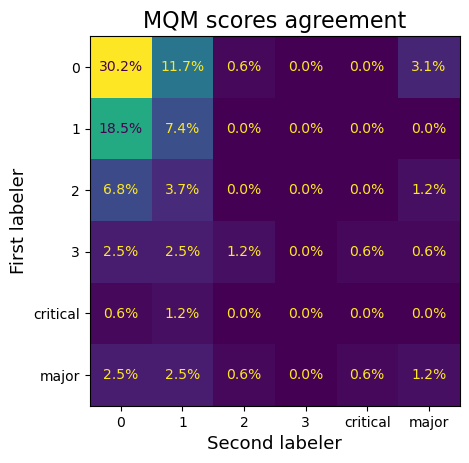

In [137]:
disp = ConfusionMatrixDisplay.from_predictions(scores_1.apply(lambda x: mqm_map[x]), scores_2.apply(lambda x: mqm_map[x]), colorbar=False, normalize='all', values_format='2.1%')
plt.title('MQM scores agreement', fontsize=16)
plt.ylabel('First labeler', fontsize=13)
plt.xlabel('Second labeler', fontsize=13)
# plt.savefig('plots/overlap_mqm_agree.jpeg')
plt.show()

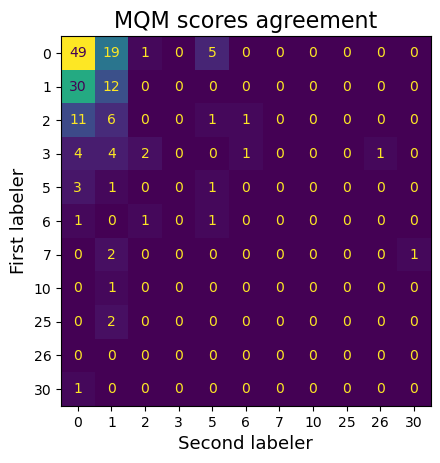

In [140]:
disp = ConfusionMatrixDisplay.from_predictions(scores_1, scores_2, colorbar=False)
plt.title('MQM scores agreement', fontsize=16)
plt.ylabel('First labeler', fontsize=13)
plt.xlabel('Second labeler', fontsize=13)
# plt.savefig('plots/overlap_mqm_agree.jpeg')
plt.show()

#### MQM category agreement

In [333]:
(overlap_df_1[['text_column', 'new_text_column']] == overlap_df_2[['text_column', 'new_text_column']]).all()

text_column        True
new_text_column    True
dtype: bool

In [334]:
cat_1 = pd.concat([
    overlap_df_1.reset_index()[['index', 'category_annotation_4']].rename({'category_annotation_4': 'category'}, axis=1),
    overlap_df_1.reset_index()[['index', 'category_annotation_5']].rename({'category_annotation_5': 'category'}, axis=1),
    overlap_df_1.reset_index()[['index', 'category_annotation_6']].rename({'category_annotation_6': 'category'}, axis=1),
])
cat_1['index'] += 90

cat_1 = pd.concat([
    cat_1,
    overlap_df_1.reset_index()[['index', 'category_annotation_1']].rename({'category_annotation_1': 'category'}, axis=1),
    overlap_df_1.reset_index()[['index', 'category_annotation_2']].rename({'category_annotation_2': 'category'}, axis=1),
    overlap_df_1.reset_index()[['index', 'category_annotation_3']].rename({'category_annotation_3': 'category'}, axis=1),
])

cat_2 = pd.concat([
    overlap_df_2.reset_index()[['index', 'category_annotation_4']].rename({'category_annotation_4': 'category'}, axis=1),
    overlap_df_2.reset_index()[['index', 'category_annotation_5']].rename({'category_annotation_5': 'category'}, axis=1),
    overlap_df_2.reset_index()[['index', 'category_annotation_6']].rename({'category_annotation_6': 'category'}, axis=1),
])
cat_2['index'] += 90

cat_2 = pd.concat([
    cat_2,
    overlap_df_2.reset_index()[['index', 'category_annotation_1']].rename({'category_annotation_1': 'category'}, axis=1),
    overlap_df_2.reset_index()[['index', 'category_annotation_2']].rename({'category_annotation_2': 'category'}, axis=1),
    overlap_df_2.reset_index()[['index', 'category_annotation_3']].rename({'category_annotation_3': 'category'}, axis=1),
])

cat_1 = cat_1[cat_1['category'] != '']
cat_2 = cat_2[cat_2['category'] != '']

cat_1['sup_cat'] = cat_1['category'].str.split(' - ') .apply(lambda x: x[0])
cat_2['sup_cat'] = cat_2['category'].str.split(' - ') .apply(lambda x: x[0])

cat_1.shape, cat_2.shape

((145, 3), (82, 3))

In [392]:
cat_1['iden'] = cat_1.groupby(['index', 'category', 'sup_cat']).cumcount()
cat_2['iden'] = cat_2.groupby(['index', 'category', 'sup_cat']).cumcount()

cat_1['iden_sup'] = cat_1.groupby(['index', 'sup_cat']).cumcount()
cat_2['iden_sup'] = cat_2.groupby(['index', 'sup_cat']).cumcount()

In [395]:
cat_m = cat_1.merge(cat_2, on=['index', 'category', 'sup_cat', 'iden'])
print('Number of identical category:', cat_m.shape[0])

cat_m = cat_1.merge(cat_2, on=['index', 'sup_cat', 'iden_sup'])
print('Number of identical sup category only:', cat_m.shape[0])

Number of identical category: 30
Number of identical sup category only: 43


# Gemini-Gold fixing

## Graphs